In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using FITSIO
using LinearAlgebra
using PythonCall
using ForwardDiff
using Plots
plt = pyimport("matplotlib")
np = pyimport("numpy")

Python module: <module 'numpy' from '/home/jaime/.julia/environments/v1.7/.CondaPkg/env/lib/python3.11/site-packages/numpy/__init__.py'>

# Analytic Margninalization

## T-Matrices wlwl dz

In [4]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
#fol = "DESY1"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../data/", fol, "/", data_set, "_files.npz"))

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairss = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [5]:
function model_cov(x;
               tracers_names=tracers_names,
               pairss=pairss,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_dz" => x[1],
                     "DESwl__1_e_dz" => x[2],
                     "DESwl__2_e_dz" => x[3],
                     "DESwl__3_e_dz" => x[4],
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, tracers_names, pairss,
                  idx, files; Nuisances=nuisances)
end;

In [6]:
d = 0.00005
n_cls = 240
m  = 4
T = zeros(n_cls, m)

for i in 1:m
    dz = zeros(m)
    e = zeros(m)
    e[i] = d
    T[:, i] = (model_cov(dz.+e) .- model_cov(dz.-e)) ./ (2*d)
end

In [7]:
dz_cov = [0.017^2 0 0 0; 
          0 0.017^2 0 0;
          0 0 0.013^2 0;
          0 0 0 0.015^2] 

4×4 Matrix{Float64}:
 0.000289  0.0       0.0       0.0
 0.0       0.000289  0.0       0.0
 0.0       0.0       0.000169  0.0
 0.0       0.0       0.0       0.000225

In [8]:
TPT = T * dz_cov * T'

240×240 Matrix{Float64}:
 6.55468e-20  3.40506e-20  2.14517e-20  …  0.0          0.0
 3.40506e-20  1.76888e-20  1.11439e-20     0.0          0.0
 2.14517e-20  1.11439e-20  7.02059e-21     0.0          0.0
 1.53237e-20  7.96042e-21  5.01503e-21     0.0          0.0
 1.18035e-20  6.13175e-21  3.86298e-21     0.0          0.0
 9.58113e-21  4.97726e-21  3.13565e-21  …  0.0          0.0
 8.07121e-21  4.19288e-21  2.6415e-21      0.0          0.0
 6.94511e-21  3.60788e-21  2.27295e-21     0.0          0.0
 6.01233e-21  3.12332e-21  1.96768e-21     0.0          0.0
 5.21803e-21  2.71069e-21  1.70772e-21     0.0          0.0
 4.53737e-21  2.3571e-21   1.48496e-21  …  0.0          0.0
 3.94869e-21  2.05129e-21  1.2923e-21      0.0          0.0
 3.43389e-21  1.78386e-21  1.12382e-21     0.0          0.0
 ⋮                                      ⋱               
 0.0          0.0          0.0             1.12259e-22  9.57897e-23
 0.0          0.0          0.0             9.50676e-23  8.11207e-23
 0

In [9]:
C_mod = Symmetric(cov_tot + TPT);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  1.26842e18   1.59641e17  -6.57338e15  …  -3.80427e15  -4.42146e15
  1.59641e17   2.63374e18   2.93227e17     -1.88945e15  -2.34235e15
 -6.57338e15   2.93227e17   4.01124e18     -1.50475e15  -1.95076e15
 -8.25376e15  -6.32952e15   4.35281e17     -1.2157e15   -1.66498e15
 -7.64114e15  -1.30102e16   3.22067e15     -9.42765e14  -1.39672e15
 -6.92276e15  -1.51406e16  -1.11653e16  …  -7.3416e14   -1.19537e15
 -7.0962e15   -1.6782e16   -1.77185e16     -5.8521e14   -1.0541e15
 -7.31311e15  -1.84349e16  -2.25220e16     -5.02965e14  -1.01232e15
 -8.35562e15  -2.18792e16  -2.74846e16     -4.65526e14  -1.06865e15
 -9.23584e15  -2.50829e16  -3.27665e16     -4.16613e14  -1.13205e15
 -1.04317e16  -2.87491e16  -3.78199e16  …  -3.75524e14  -1.19828e15
 -1.23194e16  -3.42842e16  -4.56467e16     -3.56869e14  -1.32153e15
 -1.41778e16  -3.9769e16   -5.32266e16     -3.44781e14  -1.45562e15
  ⋮                                     ⋱               
 -4.31429e14   

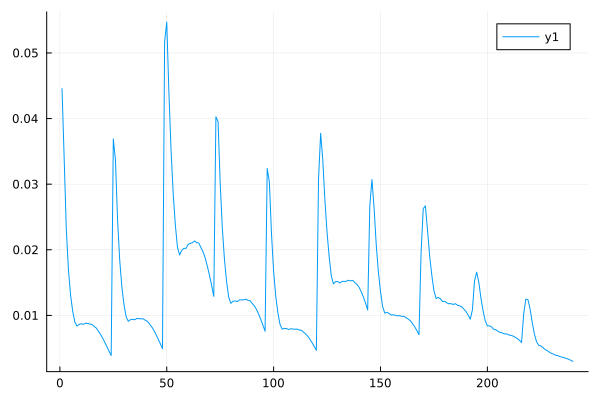

In [10]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [38]:
npzwrite("../data/DESY1/binned_40_nzs/wlwl_dz_cov_marg.npz",
        Dict("TPT" => TPT,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices wlwl

In [2]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "LSST"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

names = pyconvert(Vector{String}, meta["names"])
types = pyconvert(Vector{String}, meta["types"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0_e")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1_e")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2_e")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3_e");

In [3]:
cov_k0 = Diagonal(cov_k0)
cov_k1 = Diagonal(cov_k1)
cov_k2 = Diagonal(cov_k2)
cov_k3 = Diagonal(cov_k3)

40×40 Diagonal{Float64, Vector{Float64}}:
 1.38363e-6   ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅          2.10309e-5   ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅          1.03732e-5      ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅          …   ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
 ⋮                                   ⋱                          
  ⋅      

In [4]:
println(np.average(zs_k0, weights=nz_k0))
println(np.average(zs_k1, weights=nz_k1))
println(np.average(zs_k2, weights=nz_k2))
println(np.average(zs_k3, weights=nz_k3))

0.3593318851787447
0.4909224834984977
0.7658070710228834
0.9799214358359419


In [15]:
function model_cov0(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => x,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               names=names,
               types=types,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => x,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               names=names,
               types=types,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => x,
                     "DESwl__3_e_nz" => nz_k3,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               names=names,
               types=types,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.30, 0.05, 0.67, 0.96, 0.81,
                          nk=512, tk_mode="EisHu", 
                          Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("A_IA" => 0,
                     "alpha_IA" => 0,

                     "DESwl__0_e_nz" => nz_k0,
                     "DESwl__1_e_nz" => nz_k1,
                     "DESwl__2_e_nz" => nz_k2,
                     "DESwl__3_e_nz" => x,
        
                     "DESwl__0_e_m" => 0.012,
                     "DESwl__1_e_m" => 0.012,
                     "DESwl__2_e_m" => 0.012,
                     "DESwl__3_e_m" => 0.012)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [16]:
d = 0.005
n_cls = 240
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
end

40


In [11]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [12]:
TT0 = T0 * (cov_k0) * T0'
TT1 = T1 * (cov_k1) * T1'
TT2 = T2 * (cov_k2) * T2'
TT3 = T3 * (cov_k3) * T3';

In [17]:
C_mod = Symmetric(cov_tot + TT0); # + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

240×240 Symmetric{Float64, Matrix{Float64}}:
  8.1983e19   -8.34756e17  -9.23863e17  …   3.21291e17   4.36219e17
 -8.34756e17   1.61534e20  -1.39161e18      5.22102e17   6.82747e17
 -9.23863e17  -1.39161e18   2.48731e20      6.60024e17   8.57172e17
 -9.19045e17  -1.39375e18  -1.64238e18      6.86605e17   9.11336e17
 -8.78191e17  -1.32979e18  -1.58855e18      6.08841e17   8.51687e17
 -8.2707e17   -1.24477e18  -1.5016e18   …   4.71361e17   7.26756e17
 -7.75993e17  -1.15799e18  -1.40663e18      2.96382e17   5.59469e17
 -7.75332e17  -1.14554e18  -1.39843e18      9.56768e16   3.80159e17
 -8.35795e17  -1.22076e18  -1.49563e18     -1.97726e17   1.30969e17
 -8.78704e17  -1.26687e18  -1.55575e18     -6.44928e17  -2.78382e17
 -9.04951e17  -1.28671e18  -1.5818e18   …  -1.26028e18  -8.6594e17
 -9.4945e17   -1.33065e18  -1.63561e18     -2.13925e18  -1.71521e18
 -9.70378e17  -1.34029e18  -1.64556e18     -3.26227e18  -2.82917e18
  ⋮                                     ⋱               
 -1.91092e17  -

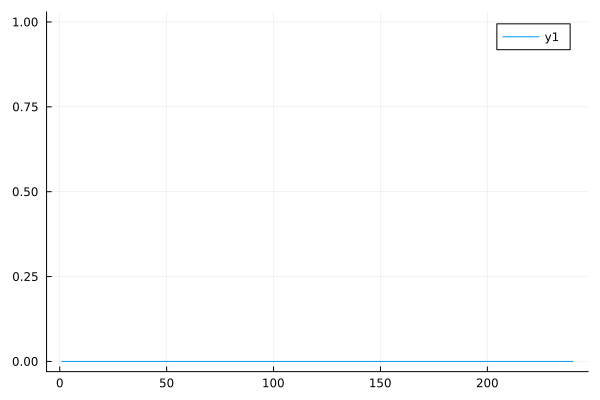

In [18]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [19]:
npzwrite("../../data/DESY1/binned_40_nzs/wlwl_cov_marg_lsst_toy.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices gcgc

In [94]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "DESY1"
data_set = "gcgc_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

names = pyconvert(Vector{String}, meta["names"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
types = pyconvert(Vector{String}, meta["types"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESgc__0_0")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESgc__1_0")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESgc__2_0")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESgc__3_0")
zs_k4, nz_k4, cov_k4 = get_nzs(nz_path, "DESgc__4_0")

([0.6551, 0.6651, 0.6751, 0.6851, 0.6951, 0.7051000000000001, 0.7151, 0.7251, 0.7351, 0.7451  …  0.9551000000000001, 0.9651, 0.9751, 0.9851, 0.9951, 1.0050999999999999, 1.0151000000000001, 1.0251, 1.0351000000000001, 1.0451], [7.122190259874889e-5, 0.00023693095142791895, 0.0007163549450023793, 0.0011461243782359425, 0.002060276981448135, 0.004010500779354668, 0.007813801770069977, 0.012445219895066476, 0.017980282024427585, 0.024881651026434092  …  0.0019871031262275337, 0.0012026898458187502, 0.000608660805254952, 0.0002656764127644467, 0.00019069985344643062, 9.321117148275464e-5, 0.0002329993835371008, 0.00011861962402017041, 6.716824627770055e-5, 2.174713749402883e-5], [2.7930037054506526e-7 0.0 … 0.0 0.0; 0.0 3.537541846902938e-7 … 0.0 0.0; … ; 0.0 0.0 … 2.775891502403637e-7 0.0; 0.0 0.0 … 0.0 2.5877452507588106e-7])

In [95]:
function model_cov0(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_nz" => x,
                     "DESgc__1_nz" => nz_k1,
                     "DESgc__2_nz" => nz_k2,
                     "DESgc__3_nz" => nz_k3,
                     "DESgc__4_nz" => nz_k4,
                     "DESgc__0_b" => 1.21,
                     "DESgc__1_b" => 1.30,
                     "DESgc__2_b" => 1.48,
                     "DESgc__3_b" => 1.64,
                     "DESgc__4_b" => 1.84)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_nz" => nz_k0,
                     "DESgc__1_nz" => x,
                     "DESgc__2_nz" => nz_k2,
                     "DESgc__3_nz" => nz_k3,
                     "DESgc__4_nz" => nz_k4,
                     "DESgc__0_b" => 1.21,
                     "DESgc__1_b" => 1.30,
                     "DESgc__2_b" => 1.48,
                     "DESgc__3_b" => 1.64,
                     "DESgc__4_b" => 1.84)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_nz" => nz_k0,
                     "DESgc__1_nz" => nz_k1,
                     "DESgc__2_nz" => x,
                     "DESgc__3_nz" => nz_k3,
                     "DESgc__4_nz" => nz_k4,
                     "DESgc__0_b" => 1.21,
                     "DESgc__1_b" => 1.30,
                     "DESgc__2_b" => 1.48,
                     "DESgc__3_b" => 1.64,
                     "DESgc__4_b" => 1.84)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_nz" => nz_k0,
                     "DESgc__1_nz" => nz_k1,
                     "DESgc__2_nz" => nz_k2,
                     "DESgc__3_nz" => x,
                     "DESgc__4_nz" => nz_k4,
                     "DESgc__0_b" => 1.21,
                     "DESgc__1_b" => 1.30,
                     "DESgc__2_b" => 1.48,
                     "DESgc__3_b" => 1.64,
                     "DESgc__4_b" => 1.84)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov4(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESgc__0_nz" => nz_k0,
                     "DESgc__1_nz" => nz_k1,
                     "DESgc__2_nz" => nz_k2,
                     "DESgc__3_nz" => nz_k3,
                     "DESgc__4_nz" => x,
                     "DESgc__0_b" => 1.21,
                     "DESgc__1_b" => 1.30,
                     "DESgc__2_b" => 1.48,
                     "DESgc__3_b" => 1.64,
                     "DESgc__4_b" => 1.84)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [96]:
d = 0.00000005
n_cls = 47
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)
T4 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
    T4[:, i] = (model_cov4(nz_k4.+e) .- model_cov4(nz_k4.-e)) ./ (2*d)
end

40


In [97]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [98]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3'
TT4 = T4 * cov_k4 * T4';

In [99]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3 + TT4);
inv_C_mod = inv(C_mod)

47×47 Symmetric{Float64, Matrix{Float64}}:
   2.5981e8      1.64835e8  …       8.34343          3.80442
   1.64835e8     3.80207e9        129.767           -9.5313
  -1.91518e8     9.73681e8        119.768         -558.661
  -7.98035e8    -2.57434e9        -63.8064         446.963
   2.70608e8    -6.26071e8          5.10514       -149.865
  -6.06005e6     5.71371e5  …   -2339.74         -1293.33
  -7.26904e5    -4.78158e7     -20606.9           -709.717
   1.78126e6    -3.00683e7     -21041.7          66833.3
   1.30021e7     3.52879e7     -14061.9         -73545.3
  -5.83219e5     4.39251e7      -8639.51         44283.4
  -4.4013e6     -2.03489e7  …  -36105.6          78066.0
   2.03846e7     1.25473e8      75468.5              1.77565e5
   1.85211e7     7.19971e7      71751.2          27452.9
   ⋮                        ⋱       ⋮           
   2.4381       77.3769     …       2.36413e10       3.23956e9
   0.681344     18.7367             2.65804e10      -1.6766e11
 -36.7411       15.

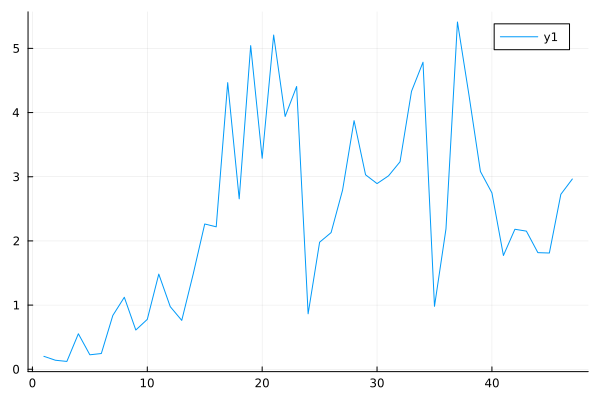

In [100]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [101]:
npzwrite("../../data/DESY1/binned_40_nzs/gcgc_cov_marg.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "TPT3" => TT4,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

## T-Matrices gcgc - LSST

In [102]:
#println("My id is ", myid(), " and I have ", Threads.nthreads(), " threads")

fol = "LSST"
data_set = "gcgc_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

names = pyconvert(Vector{String}, meta["names"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
types = pyconvert(Vector{String}, meta["types"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"])

nz_path = "../../data/DESY1/binned_40_nzs/"
zs_k0, nz_k0, cov_k0 = get_nzs(nz_path, "DESwl__0")
zs_k1, nz_k1, cov_k1 = get_nzs(nz_path, "DESwl__1")
zs_k2, nz_k2, cov_k2 = get_nzs(nz_path, "DESwl__2")
zs_k3, nz_k3, cov_k3 = get_nzs(nz_path, "DESwl__3")

(Float32[0.06, 0.099999994, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42000002  …  1.26, 1.3, 1.34, 1.38, 1.4200001, 1.46, 1.5, 1.54, 1.5799999, 1.62], [0.0009240673730447433, 0.005814852428634714, 0.0043443927624754715, 0.0041160596873804104, 0.009895392517209878, 0.003943404553941104, 0.005722829819267932, 0.0033400048064060497, 0.007211179232808158, 0.0031238118244838213  …  0.031763332972974484, 0.00911825258939116, 0.011404821613995498, 0.014876208760203333, 0.013381480231233972, 0.01378891718945615, 0.007705600228305088, 0.0036701150619442577, 0.0035936918557433503, 0.003960094429040499], [1.3836301678444849e-6 -1.3977640396582891e-8 … -1.395804086718494e-10 1.0317296311408265e-9; -1.3977640396582891e-8 2.103089987389617e-5 … -3.98300461516264e-9 -3.6854268751077994e-9; … ; -1.395804086718494e-10 -3.98300461516264e-9 … 3.774187479133305e-6 3.6353211990832475e-9; 1.0317296311408265e-9 -3.6854268751077994e-9 … 3.6353211990832475e-9 4.229474497801167e-6])

In [103]:
function model_cov0(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESwl__0_nz" => x,
                     "DESwl__1_nz" => nz_k1,
                     "DESwl__2_nz" => nz_k2,
                     "DESwl__3_nz" => nz_k3)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov1(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESwl__0_nz" => nz_k0,
                     "DESwl__1_nz" => x,
                     "DESwl__2_nz" => nz_k2,
                     "DESwl__3_nz" => nz_k3)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov2(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESwl__0_nz" => nz_k0,
                     "DESwl__1_nz" => nz_k1,
                     "DESwl__2_nz" => x,
                     "DESwl__3_nz" => nz_k3)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

function model_cov3(x;
               names=names,
               types=types,
               pairs=pairs,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    cosmology = Cosmology(0.24, 0.04, 0.67, 0.96, 0.81,
                          tk_mode="EisHu", Pk_mode="Halofit")
    #cosmology.settings.cosmo_type = Real
    nuisances = Dict("DESwl__0_nz" => nz_k0,
                     "DESwl__1_nz" => nz_k1,
                     "DESwl__2_nz" => nz_k2,
                     "DESwl__3_nz" => x)
    
    return Theory(cosmology, names, types, pairs,
                  idx, files; Nuisances=nuisances)
end;

In [104]:
d = 0.00000005
n_cls = 34
m  = length(nz_k0)
println(m)
T0 = zeros(n_cls, m)
T1 = zeros(n_cls, m)
T2 = zeros(n_cls, m)
T3 = zeros(n_cls, m)

for i in 1:m
    e = zeros(m)
    e[i] = d
    T0[:, i] = (model_cov0(nz_k0.+e) .- model_cov0(nz_k0.-e)) ./ (2*d)
    T1[:, i] = (model_cov1(nz_k1.+e) .- model_cov1(nz_k1.-e)) ./ (2*d)
    T2[:, i] = (model_cov2(nz_k2.+e) .- model_cov2(nz_k2.-e)) ./ (2*d)
    T3[:, i] = (model_cov3(nz_k3.+e) .- model_cov3(nz_k3.-e)) ./ (2*d)
end

40


In [105]:
#T0 = ForwardDiff.jacobian(model_cov0, nz_k0)
#T1 = ForwardDiff.jacobian(model_cov1, nz_k1)
#T2 = ForwardDiff.jacobian(model_cov2, nz_k2)
#T3 = ForwardDiff.jacobian(model_cov3, nz_k3)

In [106]:
TT0 = T0 * cov_k0 * T0'
TT1 = T1 * cov_k1 * T1'
TT2 = T2 * cov_k2 * T2'
TT3 = T3 * cov_k3 * T3';

In [107]:
C_mod = Symmetric(cov_tot + TT0 + TT1 + TT2 + TT3);
inv_C_mod = inv(C_mod)

34×34 Symmetric{Float64, Matrix{Float64}}:
  2.59497e11  -9.21404e11   7.65828e10  …  -1.53358e11   1.80368e10
 -9.21404e11   6.48818e12  -4.20639e11      6.31852e11  -1.81365e11
  7.65828e10  -4.20639e11   2.31257e13     -6.82092e12   1.14902e12
  6.20622e11  -8.52513e12  -1.36178e13     -3.4018e12   -1.89021e12
  9.07295e10  -6.36483e12  -3.91834e13      2.23098e13   3.02052e11
 -3.24337e11   1.63872e12   6.0486e11   …  -1.64809e10   7.45115e10
  1.4379e12   -8.87524e12   5.68028e11     -2.36471e12  -5.37882e10
  1.55228e11  -4.97107e11  -2.2482e13       1.42625e13   2.21112e12
 -1.45344e12   1.14985e13   1.22891e13      2.51601e12   6.89147e12
 -5.4325e11    7.62731e12   4.22128e13     -6.3221e13    1.15935e13
 -3.54737e11  -3.12132e12   1.05789e13  …  -1.56246e12  -2.42998e12
 -1.11748e12   3.67202e12  -1.71524e13      5.95626e12  -1.68001e13
  6.72558e11  -2.92869e12  -5.12659e12      4.1584e13   -3.18238e13
  ⋮                                     ⋱               
  1.18905e12  -6

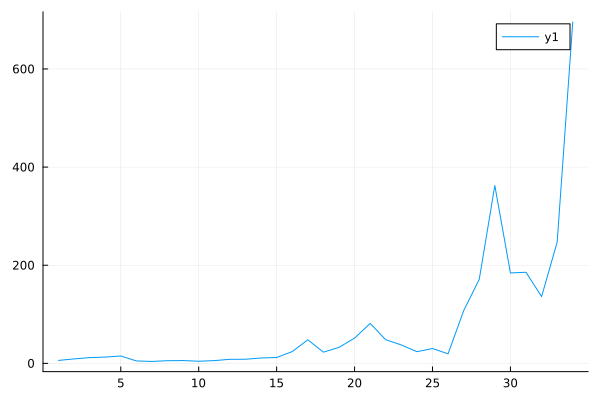

In [108]:
using Plots
plot(abs.(diag(cov_tot) .- diag(C_mod)) ./ diag(cov_tot))

In [109]:
npzwrite("../../data/DESY1/binned_40_nzs/gcgc_cov_marg_lsst.npz",
        Dict("TPT0" => TT0, "TPT1" => TT1,
             "TPT2" => TT2, "TPT3" => TT3,
             "cov_marg" => C_mod,
             "inv_cov_marg" => inv_C_mod))

# Likelihood

In [157]:
fol = "LSST"
data_set = "wlwl_Nzs_40"
meta = np.load(string("../../data/", fol, "/", data_set, "_meta.npz"))
files = npzread(string("../../data/", fol, "/", data_set, "_files.npz"))

names = pyconvert(Vector{String}, meta["names"])
types = pyconvert(Vector{String}, meta["types"])
pairss = pyconvert(Vector{Vector{String}}, meta["pairs"]);
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [158]:
length(data_vector)

240

In [173]:
nz_0 = files["nz_DESwl__0"][2, 1:40]
nz_1 = files["nz_DESwl__1"][2, 1:40]
nz_2 = files["nz_DESwl__2"][2, 1:40]
nz_3 = files["nz_DESwl__3"][2, 1:40]
z_0 = files["nz_DESwl__0"][1, 1:40]
z_1 = files["nz_DESwl__1"][1, 1:40]
z_2 = files["nz_DESwl__2"][1, 1:40]
z_3 = files["nz_DESwl__3"][1, 1:40]

40-element Vector{Float64}:
 0.05999999865889549
 0.09999999403953552
 0.14000000059604645
 0.18000000715255737
 0.2199999988079071
 0.25999999046325684
 0.30000001192092896
 0.3400000035762787
 0.3799999952316284
 0.42000001668930054
 0.4599999785423279
 0.5
 0.5399999618530273
 ⋮
 1.1800000667572021
 1.2200000286102295
 1.2599999904632568
 1.2999999523162842
 1.340000033378601
 1.3799999952316284
 1.4200000762939453
 1.4600000381469727
 1.5
 1.5399999618530273
 1.5799999237060547
 1.6200000047683716

In [177]:
nuisances = Dict("DESwl__0_nz"=> nz_0,
                 "DESwl__1_nz"=> nz_1,
                 "DESwl__2_nz"=> nz_2,
                 "DESwl__3_nz"=> nz_3, 
                 "DESwl__0_zs"=> z_0,
                 "DESwl__1_zs"=> z_1,
                 "DESwl__2_zs"=> z_2,
                 "DESwl__3_zs"=> z_3)

cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                 #nk=1200, nz=1200, nz_pk=70,
                                 tk_mode="EisHu",
                                 Pk_mode="Halofit", 
                                 emul_path="../../emulator/files.npz")

fake_data = Theory(cosmology, names, types, pairss,
                   idx, files; Nuisances=nuisances);

nz_02 = nz_0
nz_12 = nz_1
nz_22 = nz_2
nz_32 = nz_3
nz_02[10:end] = -nz_02[10:end]
nz_12[15:end] = -nz_12[15:end]
nz_22[20:end] = -nz_22[20:end]
nz_32[25:end] = -nz_32[25:end]

nuisances_minus = Dict("DESwl__0_nz"=> nz_02,
                     "DESwl__1_nz"=> nz_12,
                     "DESwl__2_nz"=> nz_22,
                     "DESwl__3_nz"=> nz_32, 
                     "DESwl__0_zs"=> z_0,
                     "DESwl__1_zs"=> z_1,
                     "DESwl__2_zs"=> z_2,
                     "DESwl__3_zs"=> z_3)

fake_data_minus = Theory(cosmology, names, types, pairss,
                   idx, files; Nuisances=nuisances_minus);

nuisances = Dict("DESwl__0_nz"=> nz_0,
                 "DESwl__1_nz"=> nz_1,
                 "DESwl__2_nz"=> nz_2,
                 "DESwl__3_nz"=> nz_3, 
                 "DESwl__0_zs"=> z_0,
                 "DESwl__1_zs"=> z_1,
                 "DESwl__2_zs"=> z_2,
                 "DESwl__3_zs"=> z_3)

cosmology_lin = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                 #nk=1200, nz=1200, nz_pk=70,
                                 tk_mode="EisHu",
                                 Pk_mode="linear", 
                                 emul_path="../../emulator/files.npz")

fake_data_lin = Theory(cosmology_lin, names, types, pairss,
                       idx, files; Nuisances=nuisances);

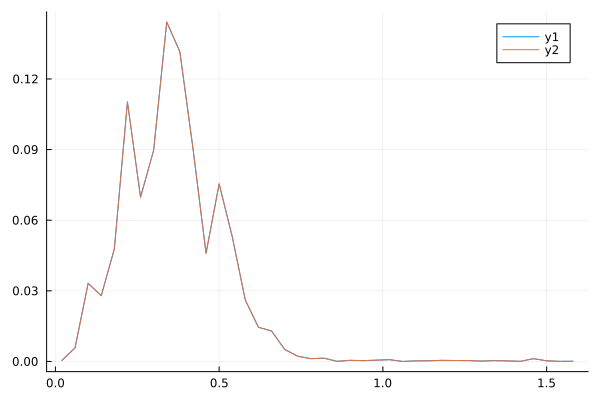

In [178]:
plot(z_0, nz_0)
plot!(z_0, nz_02)

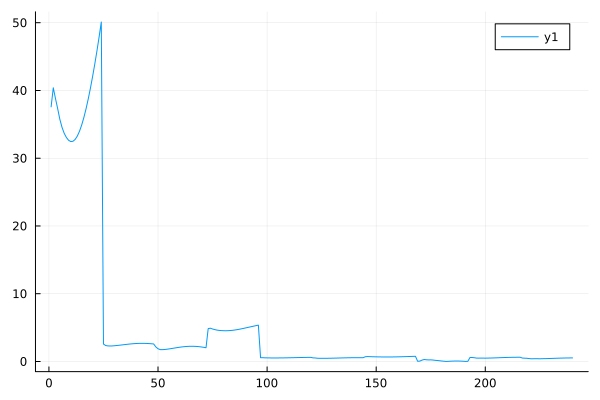

In [176]:
plot(abs.(fake_data .- fake_data_minus)./fake_data)

In [104]:
using Interpolations
using NumericalIntegration
using Trapz
WeakLensingTracer_test(cosmo::Cosmology, z_n, nz; kwargs...) = begin
    
    nz_int = linear_interpolation(z_n, nz, extrapolation_bc=0)
    
    cosmo_type = cosmo.settings.cosmo_type
    res = cosmo.settings.nz
    z_w = range(0.00001, stop=z_n[end], length=res)
    dz_w = (z_w[end]-z_w[1])/res
    nz_w = nz_int(z_w)
    chi = cosmo.chi(z_w)
    
    #nz_norm = sum(0.5 .* (nz_w[1:res-1] .+ nz_w[2:res]) .* dz_w)
    nz_norm = integrate(z_w, nz_w, SimpsonEven())

    # Calculate chis at which to precalculate the lensing kernel
    # OPT: perhaps we don't need to sample the lensing kernel
    #      at all zs.
    # Calculate integral at each chi
    w_itg(chii) = @.(nz_w*(1-chii/chi))
    w_arr = zeros(cosmo_type, res)
    @inbounds for i in 1:res
        w_arr[i] = trapz(z_w[i:res], w_itg(chi[i])[i:res])
    end
    
    # Normalize
    CLIGHT_HMPC = 1.
    H0 = cosmo.cosmo.h/CLIGHT_HMPC
    lens_prefac = 1.5*cosmo.cosmo.Ωm*H0^2
    w_arr = @. w_arr * chi * lens_prefac * (1+z_w) / nz_norm
    
    if kwargs[:IA_params] != [0.0, 0.0]
        hz = Hmpc(cosmo, z_w)
        As = get_IA(cosmo, z_w, kwargs[:IA_params])
        corr =  @. As * (nz_w * hz / nz_norm)
        w_arr = @. w_arr - corr
    end
    
    # Interpolate
    # Fix first element
    chi[1] = 0.0
    wint = linear_interpolation(chi, w_arr, extrapolation_bc=0)
    b = kwargs[:mb]+1.0 
    WeakLensingTracer(w_arr, chi, wint, b)
end


WeakLensingTracer_test (generic function with 1 method)

In [115]:

files["nz_DESwl__0"][2, 1:40]

40-element Vector{Float64}:
 0.0004258759916784182
 0.005785494453322135
 0.03319039209458998
 0.02791187844942494
 0.04779067581698762
 0.1102394534278019
 0.06980984178506984
 0.0896911299198813
 0.14420249979491997
 0.13156565183825664
 0.09059722340474397
 0.045927449730212316
 0.07544204488235291
 ⋮
 0.00028961701583090954
 0.0004745207144295495
 0.00040520543602438604
 0.00037348757434873517
 0.00016314549145583345
 0.0003535358397730359
 0.00023685913644803765
 5.858345770232954e-5
 0.0011882790933025486
 0.00027233508733941447
 4.6465705722096596e-5
 9.004693600917713e-5

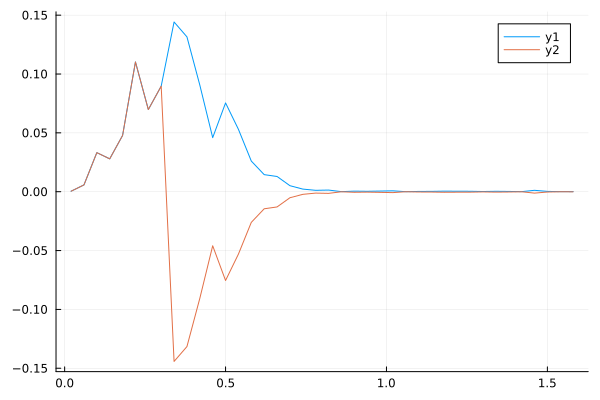

In [127]:
zz = files["nz_DESwl__0"][1, 1:40]
nz1 = files["nz_DESwl__0"][2, 1:40]
nz2 = files["nz_DESwl__0"][2, 1:40]
nz2[9:end] = -nz2[9:end]
plot(zz, nz1)
plot!(zz, nz2)

In [128]:
ts1 = WeakLensingTracer_test(cosmology, zz, nz1; mb=0.0, IA_params=[0.0, 0.0])
ts2 = WeakLensingTracer_test(cosmology, zz, nz2; mb=0.0, IA_params=[0.0, 0.0])
ls = [30, 100, 2000]
cls_11 = angularCℓs(cosmology, ts1, ts1, ls)
cls_21 = angularCℓs(cosmology, ts1, ts2, ls)
println(cls_21)

[750240.8362872981, 168573.58721004069, 3504.3057947516036]


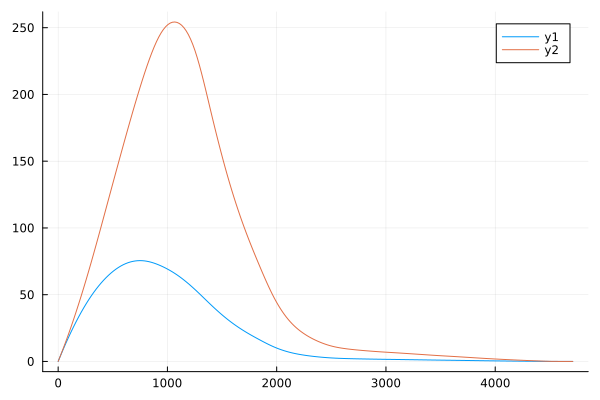

In [129]:
plot(ts1.chis, ts1.warr)
plot!(ts2.chis, ts2.warr)


In [130]:
print((cls_11.-cls_21)./cls_11)

[-1.494510413929486, -1.540157600930732, -1.8586389962390724]

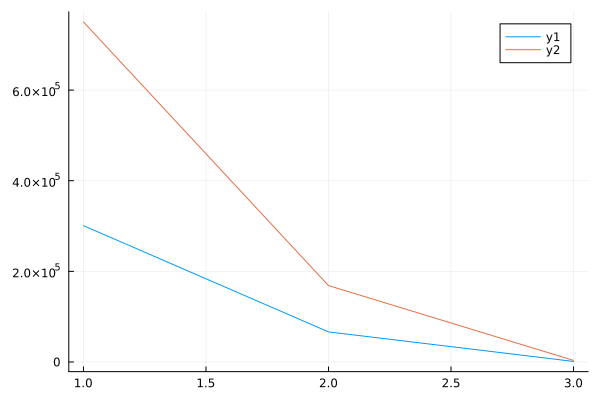

In [143]:
plot(cls_11)
plot!(cls_21)

In [87]:
println(ts1.warr[10],ts2.warr[10])

4.896342261751374e-64.896342261751374e-6


In [66]:
npzwrite("jaime_cls.npz", Dict("cls"=> fake_data, "cls_lin"=> fake_data_lin))

In [69]:
fake_data == fake_data_minus

true

In [6]:
jaime_ccl_cls = npzread("jaime_ccl_cls.npz")
jaime_ccl_cls
#jaime_ccl_cls = pyconvert(Vector{Float64}, jaime_ccl_cls["cls"]);

In [7]:
plot(abs.(fake_data .- jaime_ccl_cls) ./ jaime_ccl_cls)

LoadError: ArgumentError: broadcasting over dictionaries and `NamedTuple`s is reserved

In [8]:
plot(abs.(data_vector .- jaime_ccl_cls) ./ jaime_ccl_cls)

LoadError: ArgumentError: broadcasting over dictionaries and `NamedTuple`s is reserved

In [9]:
function get_cls(Ωm, s8;
               tracers_names=tracers_names,
               pairss=pairss,
               idx=idx,
               cov_tot=cov_tot, 
               files=files) 

    Ωb = 0.05
    h = 0.67
    ns = 0.96

    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    DESwl__0_b = 1.21
    DESwl__1_b = 1.30
    DESwl__2_b = 1.48
    DESwl__3_b = 1.64

    nuisances = Dict("DESwl__0_b" => DESwl__0_b,
                     "DESwl__1_b" => DESwl__1_b,
                     "DESwl__2_b" => DESwl__2_b,
                     "DESwl__3_b" => DESwl__3_b,)
    
    
    return Theory(cosmology, names, types, pairss,
                  idx, files; Nuisances=nuisances)
end;


In [10]:
function get_Xi2(Ωm, s8;
                 tk_mode="EisHu",
                 data=data_vector,
                 inv_cov=inv_cov_tot)

    #DESwl__0_b = 1.21
    #DESwl__1_b = 1.30
    #DESwl__2_b = 1.48
    #DESwl__3_b = 1.64

    #nuisances = Dict("DESwl__0_b" => DESwl__0_b,
    #                 "DESwl__1_b" => DESwl__1_b,
    #                 "DESwl__2_b" => DESwl__2_b,
    #                 "DESwl__3_b" => DESwl__3_b,)
    

    Ωb = 0.05
    h = 0.67
    ns = 0.96
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8;
                                     nk=300, nz=300, nz_pk=70,
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit", 
                                     emul_path="../../emulator/files.npz")
    
    theory = Theory(cosmology, names, types, pairss,
                    idx, files)
    
    diff = @.(theory-data)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [11]:
Ωms = LinRange(0.2, 0.6, 30)
s8s = LinRange(0.6, 0.9, 30)

30-element LinRange{Float64, Int64}:
 0.6,0.610345,0.62069,0.631034,0.641379,…,0.868966,0.87931,0.889655,0.9

In [12]:
LinRange(0, 3, 100)

100-element LinRange{Float64, Int64}:
 0.0,0.030303,0.0606061,0.0909091,…,2.87879,2.90909,2.93939,2.9697,3.0

In [13]:
get_Xi2(0.30, 0.81)

213.65536359786944

In [14]:
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

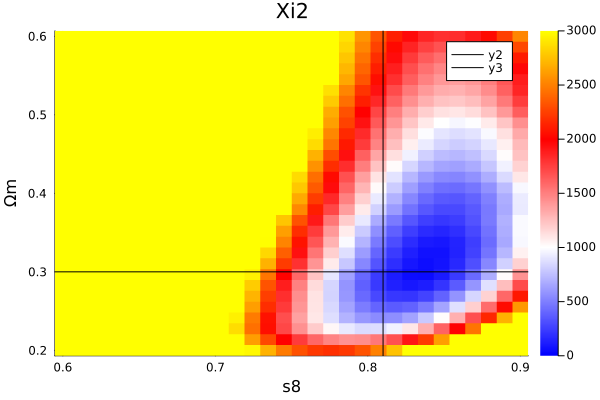

In [15]:
gr()
heatmap(s8s, Ωms, Xi2s_EisHu,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clims = (0, 3000),
    title="Xi2")
vline!([0.81], c=:black)
hline!([0.3], c=:black)